这里会展示 Bayesian GMM 的求解.

- **Bayesian GMM**
    
    mcmc
    
    variational inference

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

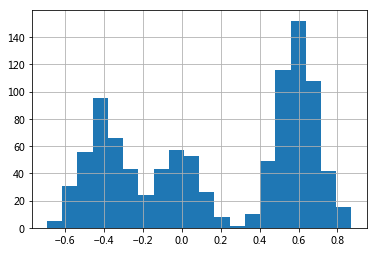

In [2]:
# 原始数据
cluster_data = pd.read_csv("./cluster_data.csv")
data = cluster_data["data"]
data_labels = cluster_data["label"]

_=data.hist(bins=20)

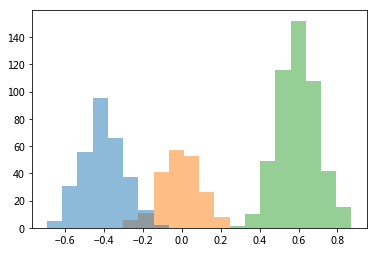

In [3]:
def plot_clusters(data_points, data_assigns):
    gby = pd.DataFrame({
            'data': data_points, 
            'assignment': data_assigns}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist() 
                 for cid in gby.groups.keys()]
    plt.hist(hist_data, 
             bins=20,
             histtype='stepfilled', alpha=.5 )

# 真实的 cluster label下绘制的直方图
plot_clusters(data, data_labels)

### Bayesian GMM

假设方差已知 $\sigma^2 = 0.01$

观测到的数据为 $ x_1, x_2, ..., x_n $, 相应的隐含类别为 $ z_1, ..., z_n $.

模型的参数为 $\theta = (\pi_1, ..., \pi_K, u_1, ..., u_K)$, 其中 $K$ 为 cluster 的数目.

为这些参数引入先验: 

$\pi = (\pi_1, ..., \pi_K) \sim Dirichlet(\alpha)$

$u_k \sim Normal(\lambda_0, \lambda_1^2) \quad \forall k = 1, 2, ..., K $

现在要估计的是分布 $p(z_1, ..., z_n, \pi_1, ..., \pi_K, u_1, ..., u_K | x_1, ..., x_n)$

下面会分别展示 MCMC 的方法 和 Variational Inference 的方法来求解模型.

### 用 Gibbs 采样求解

- **估计 $p(z_i | z_{-i}, \pi, x, u)$**

    $p(z_i = k| z_{-i}, \pi, x, u) \propto \pi_{k} N(x_i | u_{k}, \sigma^2)$

- **估计 $p(\pi | z, x, u)$**

    已经假定了 $\pi$ 的先验分布为 symmetric Dirichlet distribution, 参数为 $\alpha$. 
    
    根据多项分布和 Dirichlet distribution 的共轭性质, 容易得到后验分布为:
    
    $ p(\pi | z, x, u) = Dirchlet(\sum \delta(z_i,1) + \alpha, \sum \delta(z_i,2) + \alpha, ..., \sum \delta(z_i,K) + \alpha) $

- **估计 $p(u_i | z, x, \pi)$**

    已经假定了 $u_i$ 服从的先验分布为 $Normal(\lambda_0, \lambda_1^2)$
    
    容易得到后验分布为:
    
    $ p(u_i | z, x, \pi) = Normal(u_i | mean_i, var_i) $
    
    其中:
    
    $ var_i = (\frac{1}{\lambda_1^2} + \frac{N_k}{\sigma^2})^{-1} $
    
    $ mean_i = var_i (\frac{\lambda_0}{\lambda_1^2} + \frac{n \bar{x_i}}{\sigma^2})$
    
    上面公式中的 $N_i$ 表示的是 cluster i 中 data point 的数目, $\bar{x_i}$ 表示 cluster i 中 data point 的样本均值.

### 参考资料

- [Bayesian Mixture Models and the Gibbs Sampler](http://www.cs.columbia.edu/~blei/fogm/2015F/notes/mixtures-and-gibbs.pdf)

- [Conjugate Bayesian analysis of the Gaussian distribution](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf)

- [blog: Fitting a Mixture Model with Gibbs Sampling](https://dp.tdhopper.com/mixture-model/)

In [4]:
from scipy.stats import dirichlet, norm


class BayesianGMM:
    
    def __init__(self, n_clusters=3, variance=0.01):
        self.n_clusters = n_clusters
        self.variance = variance
        self.std = np.sqrt(self.variance)
    
    def fit(self, data, num_epoches=10, alpha=1, lambda0=0, lambda1=1, verbose=False):
        '''
        @param alpha: symmetric Dirichlet distribution 的参数
        @param lambda0: 均值的先验高斯分布的均值
        @param lambda1: 均值的先验高斯分布的标准差
        '''
        data_size = data.shape[0]
        # initialize all the parameters
        data_assigns = np.random.randint(low=0, high=self.n_clusters, size=data_size)
        prior_mean = lambda0
        prior_var = np.power(lambda1, 2)
        
        ss = pd.Series(data)
        for i_epoch in range(num_epoches):
            grouped = data.groupby(data_assigns)
            
            # sample p(\pi)
            sample_counter = grouped.count()
            self.pi = dirichlet([alpha + sample_counter.get(i, 0) for i in range(self.n_clusters)]).rvs(1)[0]

            # sample p(u_i)
            sample_mean = grouped.mean()
            var = [1 / (1/prior_var + sample_counter.get(i, 0) / self.variance) for i in range(self.n_clusters)]
            mean = np.array(var) * np.array([prior_mean / prior_var + sample_counter.get(i, 0) * sample_mean.get(i, 0) / self.variance for i in range(self.n_clusters)])
            self.u = [norm.rvs(loc=mean[i], scale=np.sqrt(var[i]), size=1)[0] for i in range(self.n_clusters)] 
            

            # sample p(z_i | z_{-i})
            for data_i, data_point in enumerate(data):
                prob = np.array([self.pi[k] * norm.pdf(data_point, loc=self.u[k], scale=self.std) for k in range(self.n_clusters)])
                prob = prob / prob.sum()
                data_assigns[data_i] = np.random.choice(self.n_clusters, p=prob)
            
            if verbose:
                print("---------- iter: %s ----------" % i_epoch)
                # print("\t".join("{}:{}".format(data_i, data_cnt) for data_i, data_cnt in sample_counter.items()))
                print("u:", self.u)
        
        return data_assigns


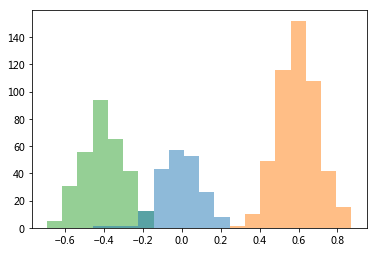

In [5]:
bgmm = BayesianGMM()
data_assigns = bgmm.fit(data, num_epoches=100)

plot_clusters(data, data_assigns)

### 用 Variational Inference 求解

联合概率公式为: $ p(X, Z, \pi, u) = p(X|Z, u) p(Z|\pi) p(\pi) p(u) $

现考虑用如下分解的变分分布: $ q(Z, \pi, u) = q(Z) q(\pi, u) $ 对 $p(Z, \pi, u | X)$ 做近似.

这里会用到 mean field theory, 其细节可以参看 PRML Chapter 10.1.1 Factorized distributions.

- **估计 $ q(Z) $**

$$ ln \, q^*(Z) \propto \mathbb{E}_{\pi}[ln \, p(Z|\pi)] + \mathbb{E}_{u}[ln \, p(X | Z, u)] $$

$$ ln \, q^*(Z) \propto \sum_{n=1}^{N} \sum_{k=1}^{K} z_{nk} ln \, \rho_{n, k} $$

$$ where \quad ln \, \rho_{nk} = \mathbb{E}_{\pi}[ln \, p(\pi_k)] + \mathbb{E}_{u} [ln \, N(x_n; u_k, \sigma^2 )] $$

两边同时做 exp, 得到:

$$ q^*(Z) \propto \prod_{n=1}^{N} \prod_{k=1}^{K} \rho_{n, k}^{z_{nk}} $$

$$ q^*(Z) = \prod_{n=1}^{N} \prod_{k=1}^{K} r_{n, k}^{z_{nk}} $$

$$ where \quad r_{nk} = \frac{\rho_{nk}}{\sum_{j=1}^{K} \rho_{nj}} $$

实际上, 对于离散分布 $q(z)$ 来说, $E[z_{nk}] = r_{nk}$, 也即 $r_{nk}$ 扮演了 responsibility 的角色.

另外, $\rho_{nk}$ 右侧两项可以分别求出:

$$ \mathbb{E}_{\pi}[ln \, p(\pi_k)] = digamma(\alpha_k) - digamma(\sum \alpha_k) $$

$$
\begin{aligned}
E_u[ln \, N(x_n; u_k, \sigma^2)] & = E_{u_k}[ln \, N(x_n; u_k, \sigma^2)] \\
& = E_{u_k}[\frac{(x_n-u_k)^2}{-2\sigma^2} - ln \, (\sqrt{2\pi}\sigma)] \\
& = \frac{1}{-2 \sigma^2} (x_n^2 - 2 x_n u_k^* + \sigma_k^{2*} + u_k^{*2}) - ln \, (\sqrt{2\pi}\sigma) 
\end{aligned}
$$

其中 $\alpha_k$ 可以从下面 $q(\pi)$ 中得到: $\alpha_k = N_k + \alpha_0$

- **估计 $ q(\pi, u) $**

$$ 
\begin{aligned}
ln \, q^*(\pi, u) & \propto ln \, p(\pi) + ln \, p(u) + \mathbb{E}_Z [ln \, p(Z | \pi)] + \mathbb{E}_Z [ln \, p(X | Z, u)] \\
& = ln \, p(\pi) + \sum_{k=1}^{K} ln \, p(u_k) + \mathbb{E}_Z [ln \, p(Z | \pi)] + \mathbb{E}_Z [ln \, p(X | Z, u)] \\
& = ln \, p(\pi) + \sum_{k=1}^{K} ln \, p(u_k) + \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}_Z [z_{nk} ln \, \pi_k] + \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}_Z [z_{nk} ln \, N(x_n | u_k, \sigma^2)]
\end{aligned}
$$

注意到, 上式右边可以按 $ \pi, u_1, ..., u_K $ 分开, 所以可以做分解 $ q(\pi, u) = q(\pi) \prod_{k} q(u_k) $.

下面分别求 $ q(\pi) $ 和 $ q(u_k) $ 的表达式.

1. **估计 $ q(\pi) $**

从前面的式子右边中分离出包含 $\pi$ 的项, 有:

$$ ln \, q^*(\pi) \propto ln \, p(\pi) + \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}_Z [z_{nk} ln \, \pi_k]] $$

两边做 exp, 有:

$$
\begin{aligned}
q^*(\pi) & \propto p(\pi)  \prod_{n=1}^{N} \prod_{k=1}^{K} exp(r_{nk} ln \, \pi_k) = p(\pi)  \prod_{n=1}^{N} \prod_{k=1}^{K} {\pi_k}^{r_{nk}} = p(\pi) \prod_{k=1}^{K} {\pi_k}^{N_k} \\
where & \quad N_k = \sum_{n=1}^{N} r_{nk}
\end{aligned}
$$

容易知道: $ q^*(\pi) = Dirichlet(\pi | N_1+\alpha, ..., N_k + \alpha)$

2. **估计 $ q(u_k) $**

从前面的式子右边中分离出包含 $u_K$ 的项, 有:

$$ 
\begin{aligned}
ln q^*(u_k) & \propto ln \, p(u_k) + \sum_{n=1}^{N} \mathbb{E}_{Z}[z_{nk} ln \, N(x_n|u_k, \sigma^2)] \\
& = ln \, p(u_k) + \sum_{n=1}^{N} r_{nk} ln \, N(x_n|u_k, \sigma^2) \\\\
q^*(u_k) & \propto p(u_k) \prod_{n=1}^{N} N(x_n|u_k, \sigma^2)^{r_{nk}}
\end{aligned}
$$

上面类似于用高斯分布做高斯分布均值的共轭先验, 可以得到均值的后验分布仍为高斯分布, 简单的配方法可以得到其均值方差如下:

$$ 
\begin{aligned}
u_k^* & = \frac{\sigma^2}{N_k \lambda_1^2 + \sigma^2} \lambda_0 + \frac{N_k \lambda_1^2}{N_k * \lambda_1^2 + \sigma^2} u_k^{ML} \\
\frac{1}{\sigma_k^{2*}} & = \frac{1}{\lambda_1^2} + \frac{N_k}{\sigma^2} \\
where & \quad u_k^{ML} = \frac{1}{N_k} \sum_{n=1}^{N} r_{nk}x_n
\end{aligned}
$$

### 参考资料

- [变分推断（二）：贝叶斯高斯混合模型](http://cairohy.github.io/2018/03/03/vi/VI-2/)

- [slide: Variational Mixture of Gaussians](https://cedar.buffalo.edu/~srihari/CSE574/Chap10/10.3VariationalGMM.pdf)

- [PRML Chapter 10.2 Variational Mixture of Gaussians]()

In [6]:
from scipy.stats import dirichlet, norm
from scipy.special import digamma

class BayesianGMM_VI:

    def __init__(self, n_clusters=3, variance=0.01):
        self.n_clusters = n_clusters
        self.variance = variance
        self.std = np.sqrt(self.variance)
    
    def fit(self, data, num_epoches=10, alpha=1, lambda0=0, lambda1=1, verbose=False):
        '''
        @param alpha: symmetric Dirichlet distribution 的参数
        @param lambda0: 均值的先验高斯分布的均值
        @param lambda1: 均值的先验高斯分布的标准差
        '''
        data_size = data.shape[0]
        data_array = np.array(data)[:, np.newaxis]

        prior_vars = np.ones(self.n_clusters) * np.power(lambda1, 2)
        prior_means = np.ones(self.n_clusters) * lambda0
        prior_alphas = np.ones(self.n_clusters) * alpha
        
        qm_alphas = np.copy(prior_alphas)
        qm_means = np.copy(prior_means)
        qm_vars = np.copy(prior_vars)

        # random initialize rs
        rhos = np.zeros([data_size, self.n_clusters])
        rs = dirichlet.rvs(size=data_size, alpha=prior_alphas)

        # iteration
        for i_epoch in range(num_epoches):
            # update q(\pi)
            qm_alphas = np.sum(rs, axis=0) + prior_alphas

            # update q(u)
            Nks = rs.sum(axis=0)
            means_mle = np.multiply(data_array, rs).sum(axis=0) / Nks
            qm_vars = 1 / (1/prior_vars + Nks / self.variance)
            ratios = np.concatenate((np.ones(self.n_clusters) * self.variance, Nks * prior_vars)).reshape([2, self.n_clusters])
            ratios = ratios / np.sum(ratios, axis=0)
            values = np.concatenate([prior_means, means_mle]).reshape([2, self.n_clusters])
            qm_means = np.multiply(ratios, values).sum(axis=0)
            
            # update q(Z)
            expect_lnpi = digamma(qm_alphas) - digamma(np.sum(qm_alphas))
            expect_lnnorm = (np.square(data_array) - 2 * data_array * qm_means + qm_vars + np.square(qm_means)) / (-2 * self.variance)
            rhos = np.exp(expect_lnpi + expect_lnnorm)
            rs = rhos / rhos.sum(axis=1, keepdims=True)
            
            if verbose:
                print("============================ i_epoch: ", i_epoch)
                print("qm_alphas:", qm_alphas)
                print("Nks:", Nks)
                print("qm_means:", qm_means)
                print("qm_vars:", qm_vars)

        return [np.random.choice(self.n_clusters, p=rs[i]) for i in range(data_size)]

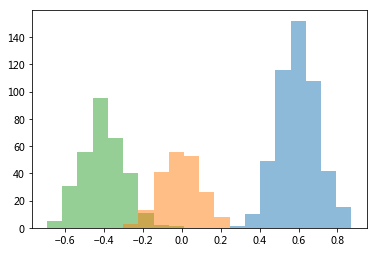

In [7]:
bgmm_vi = BayesianGMM_VI()
data_assigns_vi = bgmm_vi.fit(data, num_epoches=100, verbose=False)
# print(data_assigns_vi)
plot_clusters(data, data_assigns_vi)